In [409]:
import os
import cv2
import json
import glob
import numpy as np
import tensorflow as tf
from facenet_pytorch import MTCNN
from PIL import Image
from matplotlib import pyplot as plt

In [410]:
train_dir = 'F:\\deepfake-detection-challenge\\train_sample_videos'
test_dir = 'F:\\deepfake-detection-challenge\\test_videos'
metadata_file = 'metadata.json'
fake_image_folder = 'FAKE_faces'
real_image_folder = 'REAL_faces'
frames_per_video = 10

In [411]:
def get_video_labels(data_dir, metadata_file):
    with open(os.path.join(data_dir, metadata_file)) as f:
        metadata = json.load(f)
        labels = {}
        for key in metadata:
             # Get the label for the video, 0 for 'FAKE' and 1 for 'REAL'
            if metadata[key]['label'] == 'FAKE':
                labels[key] = 0
            elif metadata[key]['label'] == 'REAL':
                labels[key] = 1
    return labels

In [412]:
def extract_jpg_frames_from_videos(video_folder, metadata_file, fake_image_folder, real_image_folder):
    # Create face detector
    #mtcnn = MTCNN(margin=20, keep_all=True, post_process=False, device='cuda:0')
    mtcnn = MTCNN(margin=20, keep_all=True, post_process=False)
    
    dict_video_labels = get_video_labels(video_folder, metadata_file)
    for video in glob.glob(video_folder+"*/*.mp4"):
        video_name = os.path.basename(video)
        id = os.path.splitext(video_name)[0]
            
        v_cap = cv2.VideoCapture(video)
        v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
        for i in range(v_len):

            # Load frame
            success = v_cap.grab()
            if i % 30 == 0:
                success, frame = v_cap.retrieve()
            else:
                continue
            if not success:
                continue

            # Add to batch
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = Image.fromarray(frame)

            if dict_video_labels[video_name] == 0: 
                fake_face_path = os.path.join(video_folder, fake_image_folder, "{}_{}.jpg".format(id, i))
                mtcnn(frame, save_path=fake_face_path)
            elif dict_video_labels[video_name] == 1:
                real_face_path = os.path.join(video_folder, real_image_folder, "{}_{}.jpg".format(id, i))
                mtcnn(frame, save_path=real_face_path)


In [413]:
#extract_jpg_frames_from_videos(train_dir, metadata_file,fake_image_folder, real_image_folder)

In [414]:
batch_size = 32
img_height = 160
img_width = 160

In [415]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4747 files belonging to 2 classes.
Using 3798 files for training.


In [416]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4747 files belonging to 2 classes.
Using 949 files for validation.


In [417]:
class_names = train_ds.class_names
print(class_names)

['FAKE_faces', 'REAL_faces']


In [419]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [420]:
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [421]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [423]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
119/119 [==============================] - 61s 515ms/step - loss: 0.4150 - accuracy: 0.8144 - val_loss: 0.4715 - val_accuracy: 0.7819
Epoch 2/10
119/119 [==============================] - 56s 471ms/step - loss: 0.3719 - accuracy: 0.8352 - val_loss: 0.4641 - val_accuracy: 0.7871
Epoch 3/10
119/119 [==============================] - 56s 474ms/step - loss: 0.3358 - accuracy: 0.8541 - val_loss: 0.4698 - val_accuracy: 0.7745
Epoch 4/10
119/119 [==============================] - 57s 483ms/step - loss: 0.2927 - accuracy: 0.8736 - val_loss: 0.4891 - val_accuracy: 0.7871
Epoch 5/10
119/119 [==============================] - 62s 525ms/step - loss: 0.2466 - accuracy: 0.8965 - val_loss: 0.4823 - val_accuracy: 0.8135
Epoch 6/10
119/119 [==============================] - 66s 554ms/step - loss: 0.2044 - accuracy: 0.9179 - val_loss: 0.5844 - val_accuracy: 0.8093
Epoch 7/10
119/119 [==============================] - 64s 536ms/step - loss: 0.1742 - accuracy: 0.9286 - val_loss: 0.5534 - val_ac

Exception ignored in: <function tqdm.__del__ at 0x0000024A92002550>
Traceback (most recent call last):
  File "C:\Users\lingyuan\miniconda3\lib\site-packages\tqdm\std.py", line 1145, in __del__
    self.close()
  File "C:\Users\lingyuan\miniconda3\lib\site-packages\tqdm\notebook.py", line 283, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x0000024A92002550>
Traceback (most recent call last):
  File "C:\Users\lingyuan\miniconda3\lib\site-packages\tqdm\std.py", line 1145, in __del__
    self.close()
  File "C:\Users\lingyuan\miniconda3\lib\site-packages\tqdm\notebook.py", line 283, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x0000024A92002550>
Traceback (most recent call last):
  File "C:\Users\lingyuan\miniconda3\lib\site-packages\tq

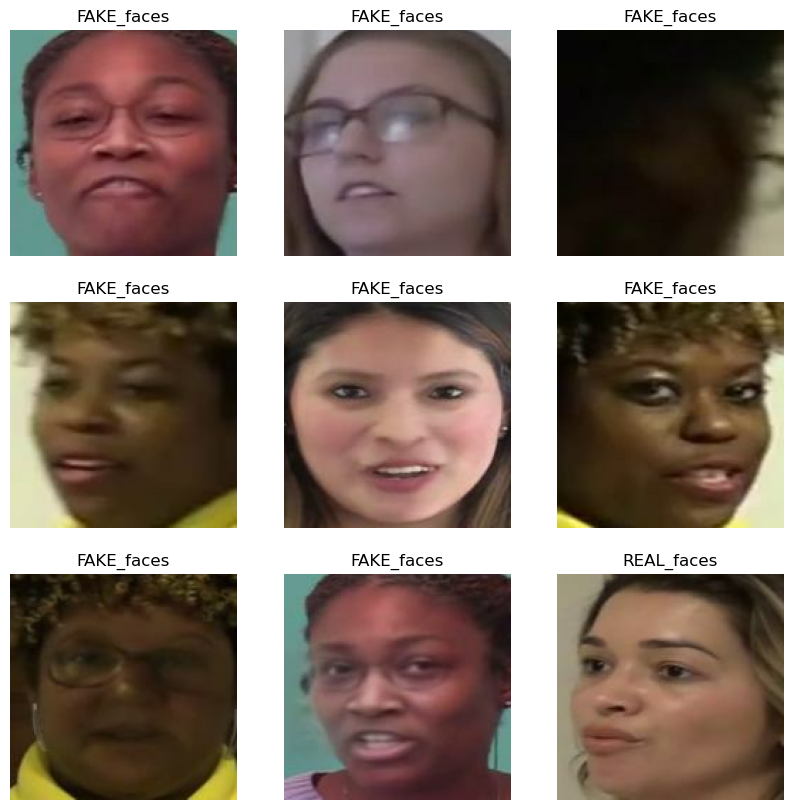

In [418]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [341]:
def extract_faces(video_folder, image_folder):
    for image in glob.glob(os.path.join(video_folder, image_folder)+"*/*.jpg"):
        # Load the image
        img = cv2.imread(image)
        image_name = os.path.basename(image)

        # Load the Haar Cascade classifier for face detection
        face_cascade = cv2.CascadeClassifier(os.path.join(video_folder, 'haarcascade_frontalface_default.xml'))

        # Convert the image to grayscale
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Detect faces in the image
        faces = face_cascade.detectMultiScale(img_gray, scaleFactor=1.3, minNeighbors=5)
        
        # Extract faces from the image
        for (x, y, w, h) in faces:
            face = img[y:y+h, x:x+w]
            #face_gray = img_gray[y:y+h, x:x+w]
            cv2.imwrite(os.path.join(video_folder, image_folder, 'faces', image_name.split('.')[0] + '_' + str(x) + str(y) + '_face.jpg'), face)


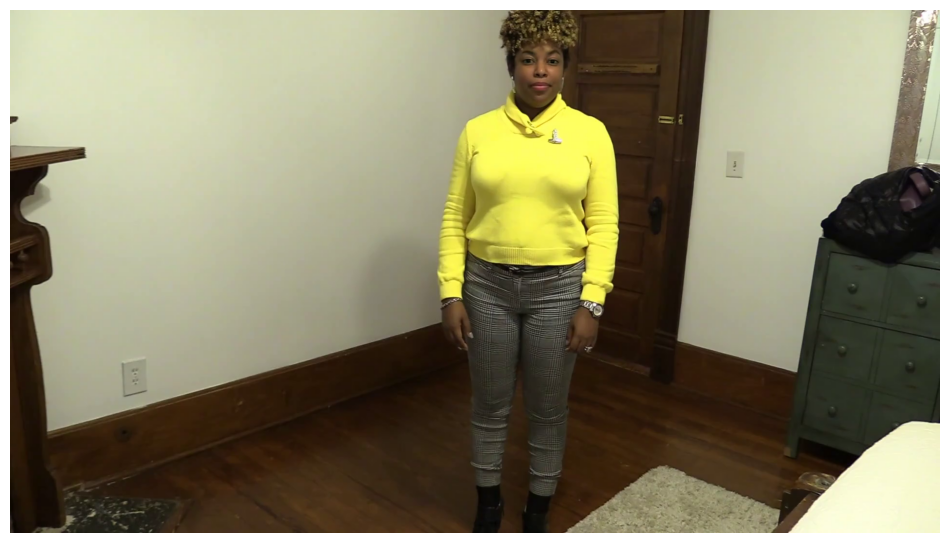

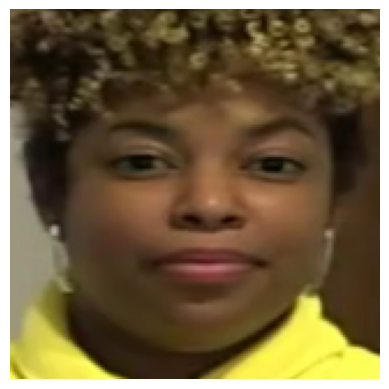

In [404]:
# Create face detector
mtcnn = MTCNN(margin=40, select_largest=False, post_process=False)

# Load a single image and display
v_cap = cv2.VideoCapture('F:\\deepfake-detection-challenge\\train_sample_videos\\agqphdxmwt.mp4')
success, frame = v_cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame = Image.fromarray(frame)

plt.figure(figsize=(12, 8))
plt.imshow(frame)
plt.axis('off')
plt.show()

# Detect face
face = mtcnn(frame)
mtcnn(frame, save_path='F:\\deepfake-detection-challenge\\train_sample_videos\\FAKE_jpegs\\faces\\aagfhgtpmv_0_face0.jpg')
# Visualize
plt.imshow(face.permute(1, 2, 0).int().numpy())
plt.axis('off');

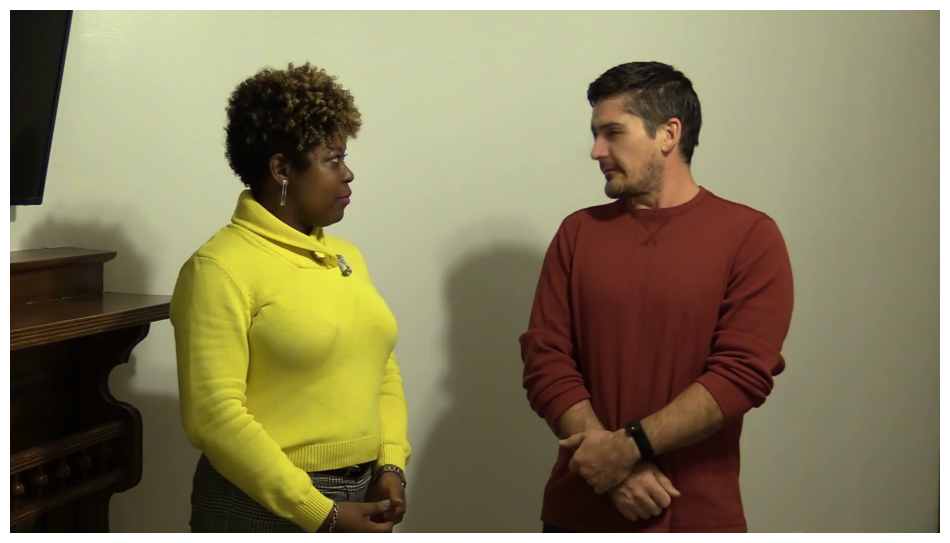

C:\Users\lingyuan\AppData\Local\Temp\ipykernel_25100\3487485687.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


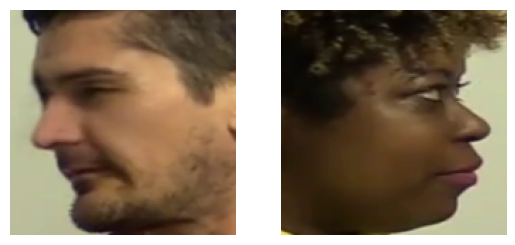

In [358]:
# Create face detector
#mtcnn = MTCNN(margin=20, keep_all=True, post_process=False, device='cuda:0')
mtcnn = MTCNN(margin=20, keep_all=True, post_process=False)

# Load a single image and display
v_cap = cv2.VideoCapture('F:\\deepfake-detection-challenge\\train_sample_videos\\avibnnhwhp.mp4')
success, frame = v_cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame = Image.fromarray(frame)

plt.figure(figsize=(12, 8))
plt.imshow(frame)
plt.axis('off')
plt.show()

# Detect face
faces = mtcnn(frame)

# Visualize
fig, axes = plt.subplots(1, len(faces))
for face, ax in zip(faces, axes):
    ax.imshow(face.permute(1, 2, 0).int().numpy())
    ax.axis('off')
fig.show()


300


Exception ignored in: <function tqdm.__del__ at 0x0000024A92002550>
Traceback (most recent call last):
  File "C:\Users\lingyuan\miniconda3\lib\site-packages\tqdm\std.py", line 1145, in __del__
    self.close()
  File "C:\Users\lingyuan\miniconda3\lib\site-packages\tqdm\notebook.py", line 283, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x0000024A92002550>
Traceback (most recent call last):
  File "C:\Users\lingyuan\miniconda3\lib\site-packages\tqdm\std.py", line 1145, in __del__
    self.close()
  File "C:\Users\lingyuan\miniconda3\lib\site-packages\tqdm\notebook.py", line 283, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
C:\Users\lingyuan\AppData\Local\Temp\ipykernel_25100\1703756766.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, whi

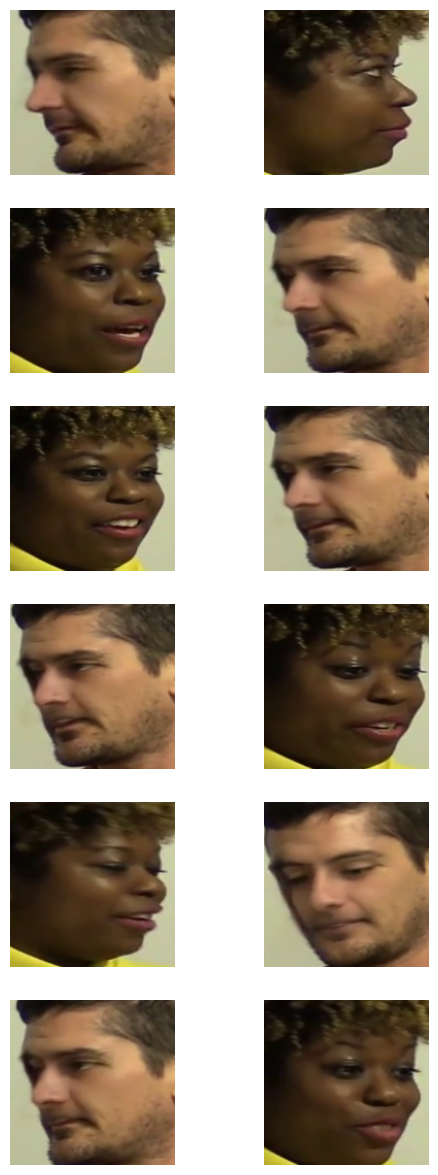

In [365]:
# Create face detector
mtcnn = MTCNN(margin=20, keep_all=True, post_process=False)

# Load a video
v_cap = cv2.VideoCapture('F:\\deepfake-detection-challenge\\train_sample_videos\\avibnnhwhp.mp4')
v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Loop through video, taking a handful of frames to form a batch
frames = []
for i in range(v_len):
    
    # Load frame
    success = v_cap.grab()
    if i % 50 == 0:
        success, frame = v_cap.retrieve()
    else:
        continue
    if not success:
        continue
        
    # Add to batch
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(Image.fromarray(frame))

# Detect faces in batch
faces = mtcnn(frames)

fig, axes = plt.subplots(len(faces), 2, figsize=(6, 15))
for i, frame_faces in enumerate(faces):
    for j, face in enumerate(frame_faces):
        axes[i, j].imshow(face.permute(1, 2, 0).int().numpy())
        axes[i, j].axis('off')
fig.show()

C:\Users\lingyuan\AppData\Local\Temp\ipykernel_25100\3646046219.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


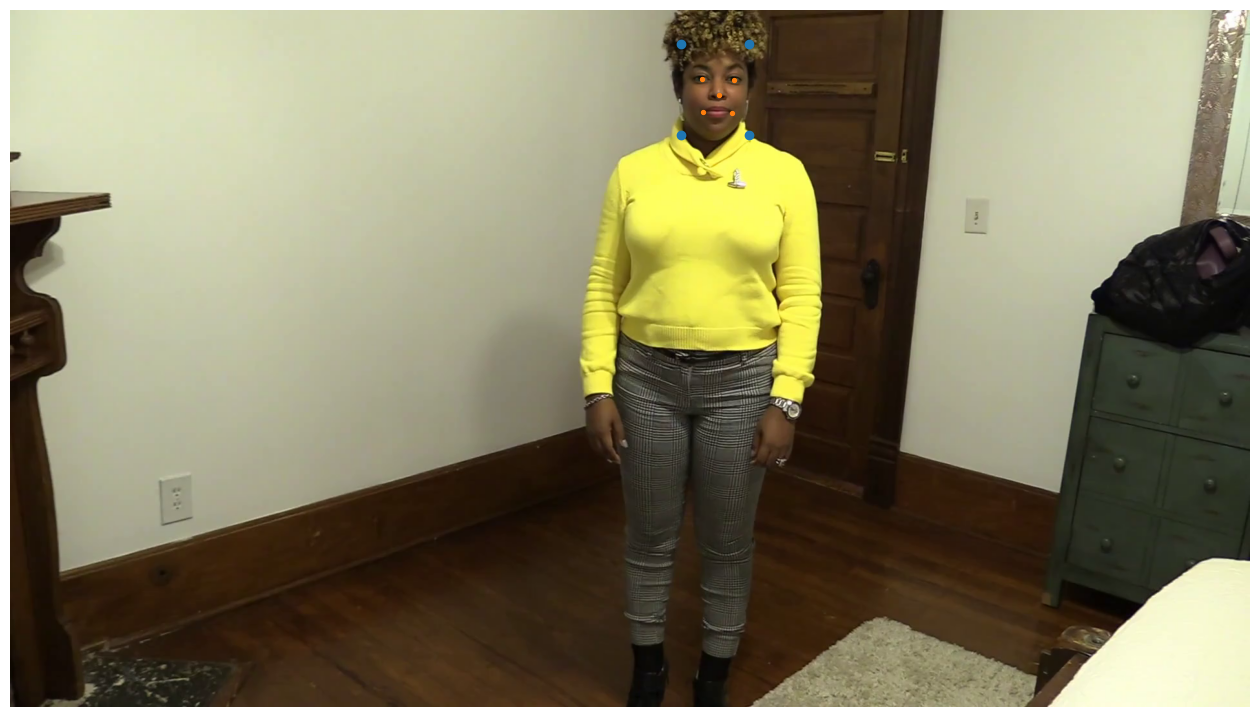

In [372]:
# Create face detector
mtcnn = MTCNN(keep_all=True)

# Load a single image and display
v_cap = cv2.VideoCapture('F:\\deepfake-detection-challenge\\train_sample_videos\\agqphdxmwt.mp4')
success, frame = v_cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame = Image.fromarray(frame)

# Detect face
boxes, probs, landmarks = mtcnn.detect(frame, landmarks=True)

# Visualize
fig, ax = plt.subplots(figsize=(16, 12))
ax.imshow(frame)
ax.axis('off')

for box, landmark in zip(boxes, landmarks):
    ax.scatter(*np.meshgrid(box[[0, 2]], box[[1, 3]]))
    ax.scatter(landmark[:, 0], landmark[:, 1], s=8)
fig.show()

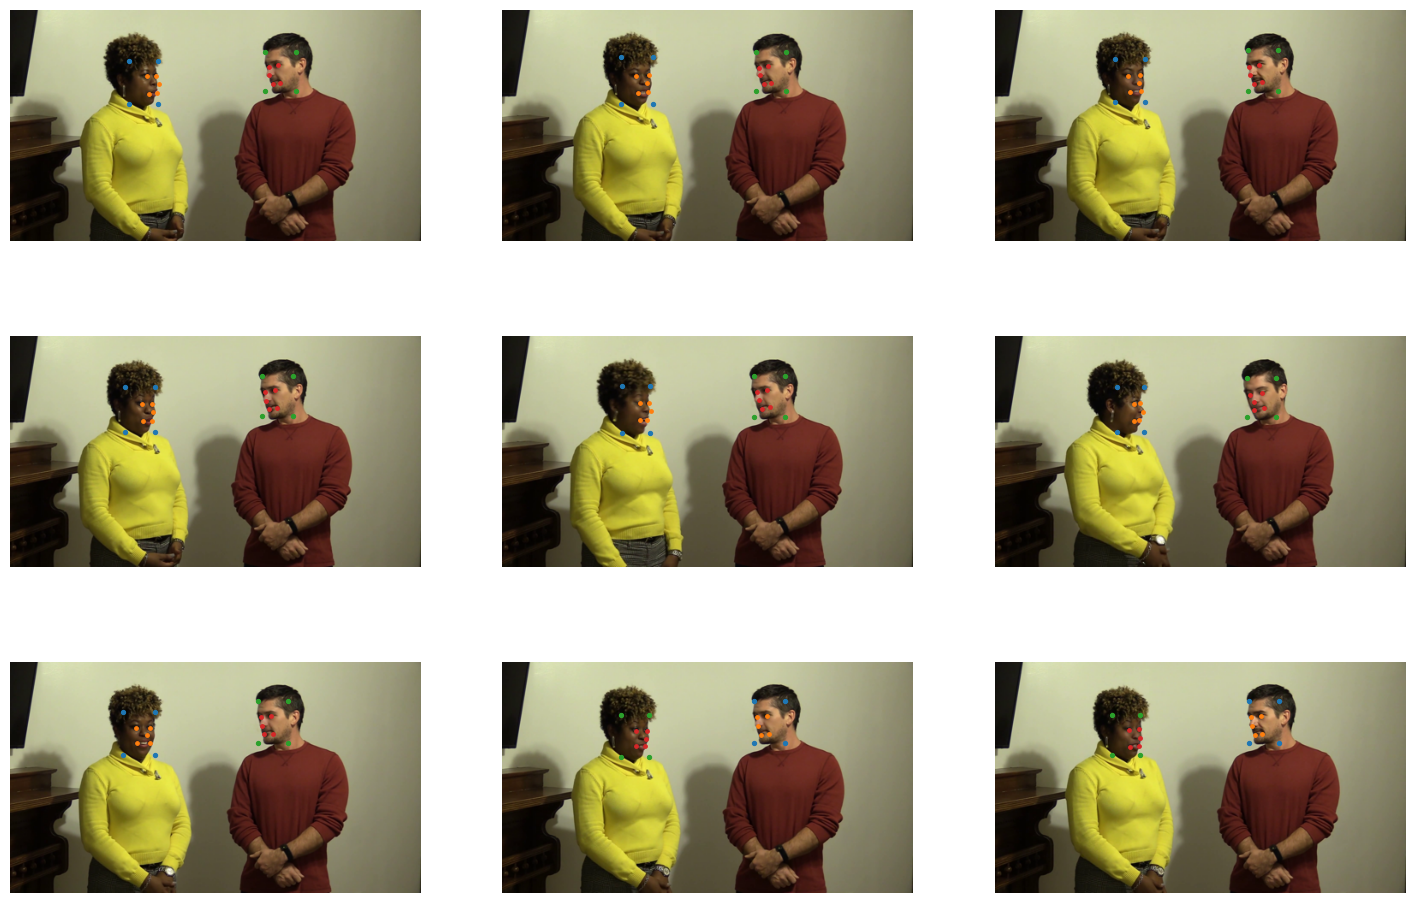

In [374]:
# Load a video
v_cap = cv2.VideoCapture('F:\\deepfake-detection-challenge\\train_sample_videos\\avibnnhwhp.mp4')

# Loop through video
batch_size = 32
frames = []
boxes = []
landmarks = []
view_frames = []
view_boxes = []
view_landmarks = []
for _ in range(v_len):
    
    # Load frame
    success, frame = v_cap.read()
    if not success:
        continue
        
    # Add to batch, resizing for speed
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = Image.fromarray(frame)
    frame = frame.resize([int(f * 0.25) for f in frame.size])
    frames.append(frame)
    
    # When batch is full, detect faces and reset batch list
    if len(frames) >= batch_size:
        batch_boxes, _, batch_landmarks = mtcnn.detect(frames, landmarks=True)
        boxes.extend(batch_boxes)
        landmarks.extend(batch_landmarks)
        
        view_frames.append(frames[-1])
        view_boxes.append(boxes[-1])
        view_landmarks.append(landmarks[-1])
        
        frames = []

# Visualize
fig, ax = plt.subplots(3, 3, figsize=(18, 12))
for i in range(9):
    ax[int(i / 3), i % 3].imshow(view_frames[i])
    ax[int(i / 3), i % 3].axis('off')
    for box, landmark in zip(view_boxes[i], view_landmarks[i]):
        ax[int(i / 3), i % 3].scatter(*np.meshgrid(box[[0, 2]], box[[1, 3]]), s=8)
        ax[int(i / 3), i % 3].scatter(landmark[:, 0], landmark[:, 1], s=6)